In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import style
style.use('ggplot')
import seaborn as sns

import re
import os
import pickle
from glob import glob
from drone_troopers.preprocessing import preprocess, create_time_series_features, get_corrupted_samples_idx
from drone_troopers import COLUMNS_CONSIDERED
import shap

#clf models
from sklearn.tree import DecisionTreeClassifier, export_text
import xgboost as xgb
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
random_state = 42
np.random.seed(random_state)

In [3]:
def get_file_paths(directory, extensions=['.csv', '.CSV', '.xlsx']):
    file_paths = []
    # Iterate over each extension
    for ext in extensions:
        # Use glob to find all files with the given extension in the directory and subdirectories
        file_paths.extend(glob(os.path.join(directory, '**', f'*{ext}'), recursive=True))
    return file_paths

In [4]:
# Specify the root directory
root_directory = os.path.join('logs', 'selected', '1')

# Get the list of file paths
file_paths_normal = get_file_paths(root_directory)
print(f'Found {len(file_paths_normal)} normal log files.')

Found 168 normal log files.


In [5]:
# Specify the root directory
root_directory = os.path.join('logs', 'selected', '-1')

# Get the list of file paths
file_paths_non_normal = get_file_paths(root_directory)
print(f'Found {len(file_paths_non_normal)} non-normal log files.')

Found 97 non-normal log files.


In [6]:
original_df = pd.DataFrame(dtype=np.float32)

for idx, x in enumerate(file_paths_normal + file_paths_non_normal) :
    # if len(time_series_data) >= 200 :
    #     break
    if x.lower().endswith('.csv') :
        df = pd.read_csv(x)
    else :
        df = pd.read_excel(x)
    if df is not None and len(df) > 0:
        df['flightId'] = idx
        
        original_df = pd.concat((original_df, df), axis=0, ignore_index=True)
original_df.shape

(844286, 235)

In [7]:
del df

In [8]:
processed_df = preprocess(original_df.copy())
processed_df = create_time_series_features(processed_df)
processed_df = processed_df.reset_index(drop=True)
processed_df_columns = processed_df.columns
processed_df.shape

(836386, 22)

In [39]:
processed_df_columns

Index(['Motor Speed (RPM)', 'Engine Speed (RPM)', 'Throttle (%)',
       'Intake Temperature (C)', 'Engine Coolant Temperature 1 (C)',
       'Engine Coolant Temperature 2 (C)', 'Barometric Pressure (kpa)',
       'Fuel Trim', 'Fuel Consumption (g/min)', 'Fuel Consumed (g)',
       'Bus Voltage (V)', 'Battery Current (A)', 'Power Generated (W)',
       'Inverter Temperature (C)', 'Target Fuel Pressure (bar)',
       'Fuel Pressure (bar)', 'Fuel Pump Speed (RPM)',
       'Cooling Pump Speed (RPM)', 'hour', 'minute', 'second', 'microsecond'],
      dtype='object')

In [9]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(processed_df)

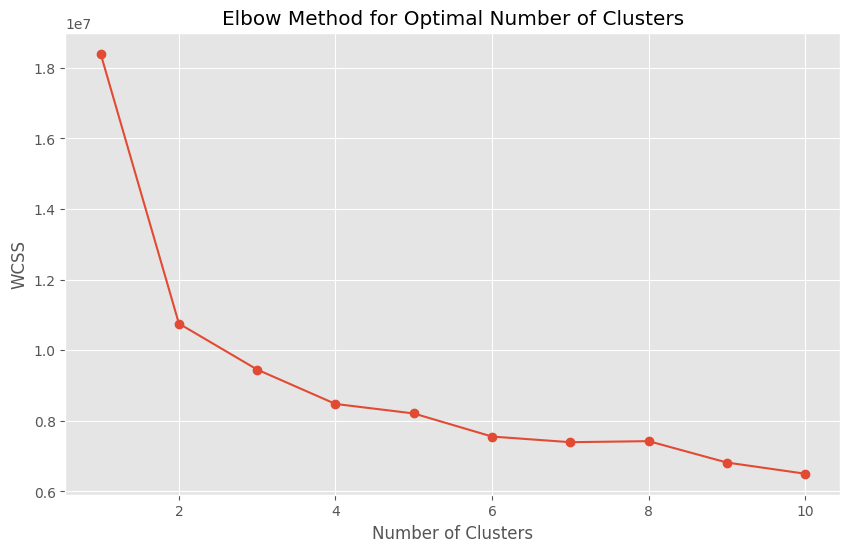

CPU times: total: 8.75 s
Wall time: 8.76 s


In [10]:
%%time
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot WCSS against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [11]:
%%time
# Fit KMeans with a specified number of clusters
n_clusters = 6  # Choose the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
kmeans.fit(df_scaled)

CPU times: total: 891 ms
Wall time: 1.11 s


KMeans(n_clusters=6, random_state=42)

In [48]:
kmeans.cluster_centers_.shape

(6, 22)

In [12]:
# Predict cluster labels
processed_df['cluster'] = kmeans.labels_

In [13]:
# Find the smallest cluster
cluster_counts = processed_df['cluster'].value_counts()

anomaly_clusters = cluster_counts.nsmallest(2).index.tolist()

# Label anomalies
processed_df['is_anomaly'] = processed_df['cluster'].isin(anomaly_clusters)

In [46]:
anomaly_clusters

[4, 3]

In [14]:
def generate_rules(row, cluster_centers, anomaly_cluster, original_features, scaler):
    if row['is_anomaly']:
        # Inverse transform the cluster centers and the row
        inverse_cluster_centers = scaler.inverse_transform(cluster_centers)
        inverse_row = scaler.inverse_transform([row[original_features].values])[0]
        
        anomaly_center = inverse_cluster_centers[anomaly_cluster]
        other_centers = np.delete(inverse_cluster_centers, anomaly_cluster, axis=0)
        
        rules = []
        for i, feature in enumerate(original_features):
            feature_value = inverse_row[i]
            mean_non_anomaly = np.mean(other_centers[:, i])
            std_non_anomaly = np.std(other_centers[:, i])
            
            if feature_value < mean_non_anomaly - std_non_anomaly:
                rule = f"{feature} was below {mean_non_anomaly - std_non_anomaly:.2f}"
                rules.append(rule)
            elif feature_value > mean_non_anomaly + std_non_anomaly:
                rule = f"{feature} was above {mean_non_anomaly + std_non_anomaly:.2f}"
                rules.append(rule)
                
        return ', '.join(rules)
    return np.nan


In [15]:
# Calculate cluster centers
cluster_centers = kmeans.cluster_centers_

In [17]:
# Display anomalies and their generated rules
anomalies = processed_df[processed_df['is_anomaly']]
display(anomalies)


,Motor Speed (RPM),Engine Speed (RPM),Throttle (%),Intake Temperature (C),Engine Coolant Temperature 1 (C),Engine Coolant Temperature 2 (C),Barometric Pressure (kpa),Fuel Trim,Fuel Consumption (g/min),Fuel Consumed (g),...,Target Fuel Pressure (bar),Fuel Pressure (bar),Fuel Pump Speed (RPM),Cooling Pump Speed (RPM),hour,minute,second,microsecond,cluster,is_anomaly
8743,8420.1,8192.0,23.0,41.0,77.0,72.0,96.0,1.05,18.9,433.0,...,3.1,3.1,3460.0,7776.0,0,24,9,40000,4,True
8744,8326.2,8192.0,16.0,41.0,77.0,72.0,96.0,1.05,10.9,433.0,...,3.1,3.3,2412.0,7776.0,0,24,9,290000,4,True
8745,8285.8,8192.0,12.0,41.0,77.0,72.0,96.0,1.05,10.6,433.0,...,3.1,3.1,2168.0,7776.0,0,24,9,540000,4,True
8746,7671.6,7568.0,11.0,41.0,77.0,72.0,96.0,1.05,9.7,433.0,...,3.1,3.1,2738.0,7536.0,0,24,9,790000,4,True
8747,6840.5,6604.0,7.0,41.0,77.0,71.0,96.0,1.05,8.6,434.0,...,3.1,3.1,2744.0,7536.0,0,24,10,40000,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835957,4108.9,4119.0,45.0,51.0,57.0,61.0,100.0,1.00,19.9,717.0,...,3.1,3.1,1844.0,5386.0,0,41,53,290000,4,True
835958,4110.1,4065.0,45.0,51.0,57.0,61.0,100.0,1.00,19.9,717.0,...,3.1,3.1,1750.0,5404.0,0,41,53,540000,4,True
835959,4023.9,4158.0,45.0,51.0,57.0,61.0,100.0,1.00,20.4,717.0,...,3.1,3.1,1715.0,5412.0,0,41,53,790000,4,True
835960,4059.6,4026.0,45.0,51.0,57.0,61.0,100.0,1.00,19.7,717.0,...,3.1,3.1,1724.0,5401.0,0,41,54,40000,4,True


In [21]:
processed_df.iloc[[anomalies.index[0]]].apply(generate_rules, axis=1, cluster_centers=cluster_centers, anomaly_cluster=anomaly_clusters, original_features=processed_df_columns, scaler=scaler).values

array(['Motor Speed (RPM) was above 5807.42, Engine Speed (RPM) was above 6043.07, Throttle (%) was above 52.46, Intake Temperature (C) was above 30.91, Engine Coolant Temperature 1 (C) was above 67.31, Engine Coolant Temperature 2 (C) was above 64.31, Barometric Pressure (kpa) was above 97.19, Fuel Trim was above 1.05, Fuel Consumption (g/min) was above 22.10, Fuel Consumed (g) was above 230.99, Bus Voltage (V) was above 48.96, Battery Current (A) was below -0.47, Power Generated (W) was above 2038.50, Inverter Temperature (C) was above 46.19, Target Fuel Pressure (bar) was above 3.93, Fuel Pressure (bar) was above 2.81, Fuel Pump Speed (RPM) was above 2140.32, Cooling Pump Speed (RPM) was above 6834.75, hour was above 0.04, minute was above 13.70, second was above 29.65, microsecond was above 416327.27'],
      dtype=object)

In [22]:
# Prepare labels: 1 for anomalies, 0 for normal samples
labels = processed_df['is_anomaly'].astype(int).values

In [23]:
# Fit a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=random_state)
dt_classifier.fit(processed_df[processed_df_columns], labels)

DecisionTreeClassifier(random_state=42)

In [24]:
rules = export_text(dt_classifier, feature_names=processed_df_columns, max_depth=20)
print(rules)

|--- Fuel Consumed (g) <= 576.50
|   |--- minute <= 26.50
|   |   |--- Fuel Consumed (g) <= 309.50
|   |   |   |--- minute <= 25.50
|   |   |   |   |--- Fuel Consumed (g) <= 273.50
|   |   |   |   |   |--- Bus Voltage (V) <= 52.42
|   |   |   |   |   |   |--- Fuel Consumed (g) <= 231.50
|   |   |   |   |   |   |   |--- Fuel Pump Speed (RPM) <= 4255.00
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Fuel Pump Speed (RPM) >  4255.00
|   |   |   |   |   |   |   |   |--- Fuel Pump Speed (RPM) <= 4260.00
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- Fuel Pump Speed (RPM) >  4260.00
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Fuel Consumed (g) >  231.50
|   |   |   |   |   |   |   |--- Fuel Pressure (bar) <= 3.55
|   |   |   |   |   |   |   |   |--- Battery Current (A) <= -13.24
|   |   |   |   |   |   |   |   |   |--- Fuel Pump Speed (RPM) <= 1876.50
|   |   |   |   |   |   |   |   |  

In [25]:
def get_tree_rules(tree, sample, feature_names):
    node_indicator = tree.decision_path(sample.reshape(1, -1))
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold

    # Collect rules
    rules = []
    for node in range(node_indicator.shape[1]):
        if node_indicator[0, node]:
            if feature[node] != -2:  # -2 indicates a leaf node
                rule = f"{feature_names[feature[node]]} <= {threshold[node]:.2f}" if sample[feature[node]] <= threshold[node] else f"{feature_names[feature[node]]} > {threshold[node]:.2f}"
                rules.append(rule)
    return ' AND '.join(rules)

In [30]:
processed_df.iloc[[anomalies.index[0]]].apply(lambda row: get_tree_rules(dt_classifier, row[processed_df_columns].values, processed_df_columns), axis=1).values

array(['Fuel Consumed (g) <= 576.50 AND minute <= 26.50 AND Fuel Consumed (g) > 309.50 AND Intake Temperature (C) > 20.50 AND Intake Temperature (C) <= 52.50 AND Fuel Pump Speed (RPM) <= 4940.00 AND Bus Voltage (V) <= 50.11 AND Intake Temperature (C) > 24.00 AND Battery Current (A) <= -22.44 AND Fuel Consumption (g/min) <= 23.20'],
      dtype=object)

In [ ]:
# processed_df['rules'] = processed_df.apply(lambda row: get_sample_rules(dt_classifier, row[processed_df_columns].values, processed_df_columns), axis=1)

In [31]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(dt_classifier)
shap_values = explainer.shap_values(df_scaled)

In [32]:
shap_values.shape

(836386, 22, 2)

In [33]:
df_scaled.shape

(836386, 22)

In [34]:
anomalies.index.max()

835961

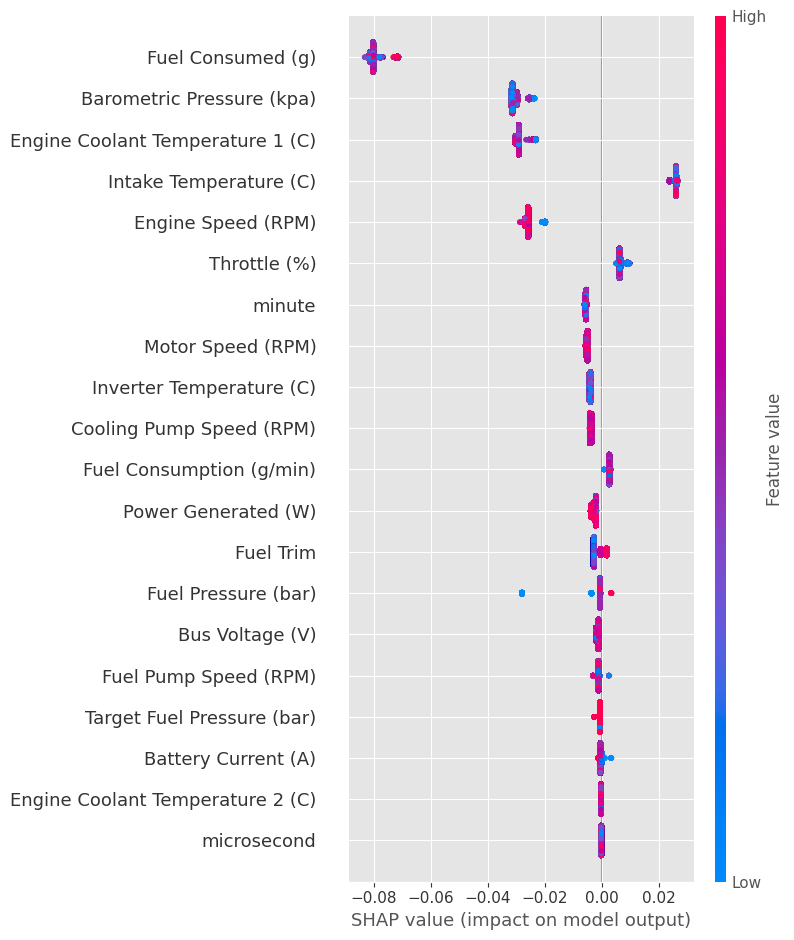

In [35]:
shap.summary_plot(shap_values[list(anomalies.index), :, 1], pd.DataFrame(df_scaled, columns=processed_df_columns).iloc[list(anomalies.index)])

In [36]:
with open(os.path.join("FinalModel",  "drone_troopers", "models", "clustering_anomaly", "scaler.pkl"), 'wb') as file:
    pickle.dump(scaler, file)

In [37]:
with open(os.path.join("FinalModel",  "drone_troopers", "models", "clustering_anomaly", "kmeans_model.pkl"), 'wb') as file:
    pickle.dump(kmeans, file)

In [38]:
with open(os.path.join("FinalModel",  "drone_troopers", "models", "clustering_anomaly", "dt_model.pkl"), 'wb') as file:
    pickle.dump(dt_classifier, file)